In [1]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs

X, _ = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)

np.random.seed(13)

X_stretched = np.dot(X, np.random.randn(2, 2))
X_stretched.shape
import matplotlib.pyplot as plt

C:\Users\danil\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


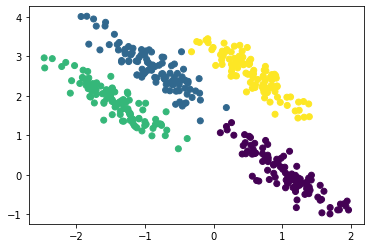

score is: -1.9184892081441416


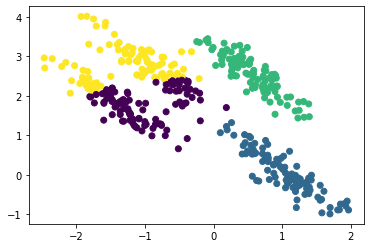

score is: -2.1512134746808775


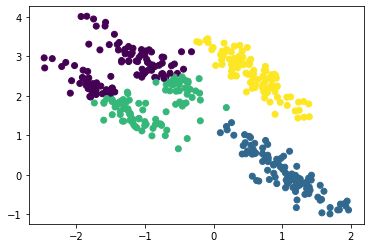

score is: -2.151632027060157


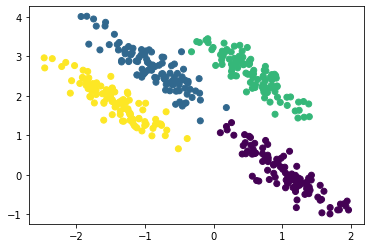

score is: -1.9184892081441418


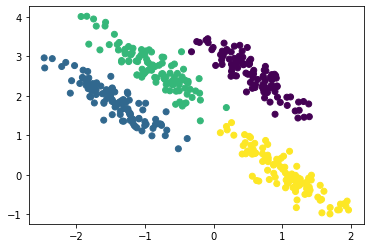

score is: -1.918482645121677


In [2]:
for i in range(5):
  from sklearn.mixture import GaussianMixture
  mixt = GaussianMixture(n_components=4, covariance_type='full', weights_init=(1/4, 1/4, 1/4, 1/4))
  colors = mixt.fit_predict(X_stretched)
  plt.scatter(X_stretched[:,0], X_stretched[:,1], c=colors)
  plt.show()
  print('score is:', mixt.score(X_stretched))

Очевидно при серии запусков, более низкий скор является критерием правильной работы

# Изучим квантили одного облака точек

[1.66510922 1.17741002 0.75852762]


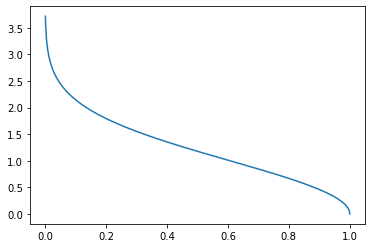

In [3]:
# функция для нормировки элипса по квантили
# https://stats.stackexchange.com/questions/64680/how-to-determine-quantiles-isolines-of-a-multivariate-normal-distribution
x = np.arange(0.001, 1.001, 0.001)
y = (- 2 * np.log(x)) ** 0.5
plt.plot(x, y)
print((- 2 * np.log([0.25, 0.5, 0.75])) ** 0.5)
plt.show()

Нарисуем хитмап функции плотности для произвольного нормального распределения, видно, почему берутся доверительные элипсы

In [4]:
curX = X_stretched[colors == colors[0]]

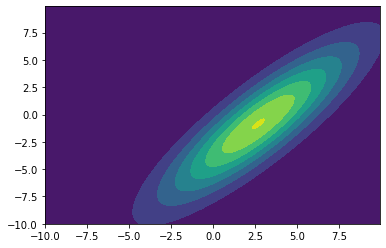

In [5]:
import itertools
def _p(X, m, sigma):
  X, m, sigma = np.array(X), np.array(m), np.array(sigma)
  return (X - m) @ sigma @ (X - m).T

def p(X, m, sigma):
  X, m, sigma = np.array(X), np.array(m), np.array(sigma)
  return 1 / (2 * np.pi * (np.linalg.det(sigma)) ** 0.5) * \
          np.exp(-0.5 * ((X - m)[:,0] ** 2 * sigma[0, 0] + \
                         2 * (X - m)[:,0] * (X - m)[:,1] * sigma[0, 1] + \
                         (X - m)[:,1] ** 2 * sigma[1, 1]
                        )
                )
# X, m, sigma = [[1, 1.1], [0.2, 1], [14, 0]], [0, 0], [[1.8,2],[2,3.4]]
sigma, m = np.cov(curX.T), np.mean(curX, axis=0)
x, y = np.arange(-10, 10, 0.1), np.arange(-10, 10, 0.1)
gridlen = len(x)
X = list(itertools.product(x, y))
p(X, m, sigma)
plt.contourf(x, y, p(X, m, sigma).reshape((gridlen, gridlen)))
plt.show()

научимся рисовать элипсы

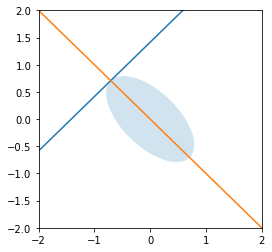

In [6]:
from matplotlib import patches as mpatches
# ellipse рисует элипс с указанными центром, квадратами осей, и углом поворота
fig = plt.gcf()
fig.set_size_inches(4, 4)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
el = mpatches.Ellipse((0, 0), 1, 2, angle = 45 + 180, alpha = 0.2)
x = np.arange(-2, 2.001, 0.001)
plt.plot(x, x + 2 ** 0.5)
plt.plot(x, -x)
ax = plt.gca()
ax.add_artist(el)
plt.show()

Ковариационная матрица - положительно определённая квадратичная форма, значит её собственные векторы ортогональны и образуют базис для приведения к каноническому виду (диагональному), в котором на диагонали стоят собственные значения.

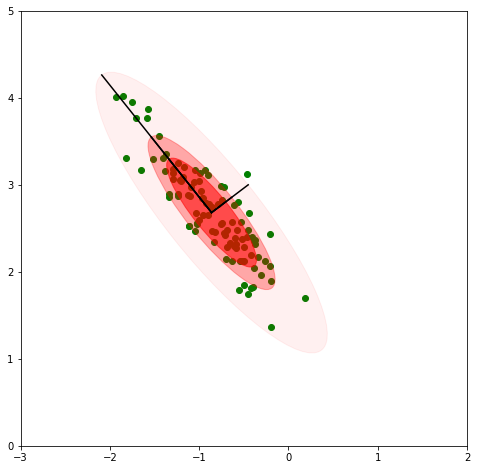

In [7]:
import scipy
import matplotlib.patches as mpatches

fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.xlim((-3, 2))
plt.ylim((-0, 5))
ax = plt.gca()

plt.scatter(curX[:,0], curX[:,1], c='g')

# ковариационная матрица (выборочная дисперсия)
def draw_ellipse(curX, quantile, ax, color='b', drawaxes=False):
  sigma = np.cov(curX.T)
  sigma_inv = np.linalg.inv(np.cov(curX.T))
  values, vectors = np.linalg.eig(sigma_inv)
  # radius
  rad = (- 2 * np.log(quantile)) ** 0.5
  # semi-major axises
  smax = 1 / values ** 0.5
  V = vectors
  _V = vectors.T
  centre = np.mean(curX, axis=0)
  # нарисуем полуоси эллипса
  if drawaxes:
    vec1 = np.vstack((centre, centre + V[:,0] * smax[0] * rad)).T
    vec2 = np.vstack((centre, centre + V[:,1] * smax[1] * rad)).T
    ax.plot(vec1[0], vec1[1], c='k')
    ax.plot(vec2[0], vec2[1], c='k')
  angle = np.arctan(V[:,0][1] / V[:,0][0]) * 180 / np.pi
  el = mpatches.Ellipse(centre, smax[0] * rad * 2, smax[1] * rad * 2, angle = angle, alpha = min(quantile + 0.05, 1), color=color)
  ax.add_artist(el)
draw_ellipse(curX, 0.25, ax, 'r', True)
draw_ellipse(curX, 0.5, ax, 'r', True)
draw_ellipse(curX, 0.01, ax, 'r', True)
plt.show()

Наконец завершим работу, нарисовав доверительные элипсы для всех множеств

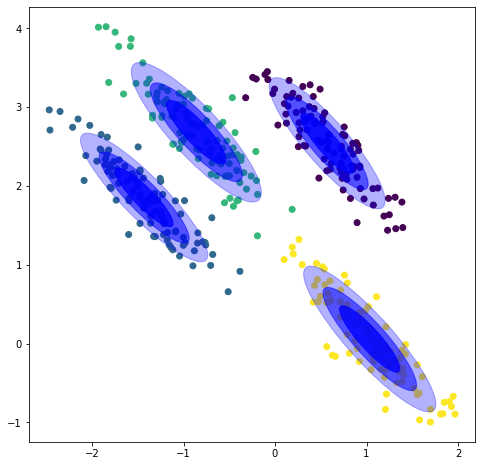

In [8]:
plt.scatter(X_stretched[:,0], X_stretched[:,1], c=colors)
mixt.weights_
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(8, 8)
for c in range(4):
  idxs = colors == c
  _curX = X_stretched[idxs]
  for quantile in [0.25, 0.5, 0.75]:
    draw_ellipse(_curX, quantile, ax, 'b')
plt.show()